In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
from gensim.models import Word2Vec
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, LSTM, Bidirectional, GRU, GlobalMaxPool1D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
import pydot
import IPython
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model


In [3]:
import seaborn as sns

In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [5]:
train = pd.read_csv('./train.csv')
#test = pd.read_csv('./test.csv')


In [6]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_y = train[list_classes].values
train_x= train["comment_text"]


In [7]:
np.random.seed(42)

num_samples = 80000
train_samples = 48000
val_samples = int(train_samples + ((num_samples-train_samples)/2))
samples = np.random.choice(len(train_x), num_samples)
train_X = train_x[samples[0:train_samples]]
train_Y = train_y[samples[0:train_samples]]
val_X = train_x[samples[train_samples:val_samples]]
val_Y = train_y[samples[train_samples: val_samples]]
test_X = train_x[samples[val_samples:num_samples]]
test_Y = train_y[samples[val_samples:num_samples]]

In [8]:
print(train_X.head())
print(test_X.head())

121958    You are WRONG. \n\nJustin Thompson is mentione...
146867    "\n\n British Bands?  \n\nI think you've mista...
131932    I won't stop that. Sometimes Germanic equals G...
103694    Back it up. Post the line here with the refere...
119879    REDIRECT Talk:John Loveday (experimental physi...
Name: comment_text, dtype: object
41070     G'day Mackequine, and welcome to Wikipedia!\n\...
11974     Add Media Matters back\n add Opposition to the...
114031    "==Really, guys?==\nIf you hate President Bush...
18608     Effects under £2000 - dated 24th August, 1860....
150547    "\nJust a heads up those people asking you to ...
Name: comment_text, dtype: object


In [9]:
train_y_df = pd.DataFrame(train_Y, columns=list_classes)
rowsums=train_y_df.iloc[:,0:].sum(axis=1)
train_y_df['clean']=(rowsums==0)
print(train_y_df['clean'].sum())
# Print the DataFrame
print(train_y_df)
class_counts = train_y_df.iloc[:, :-1].sum()

# Calculate the minimum count among the non-"clean" classes
max_count = class_counts[class_counts > 0].max()

# Sample rows with "clean" class to match the minimum count
clean_rows = train_y_df[train_y_df['clean']].sample(n=max_count, random_state=42)

# Filter out the "clean" rows from the original DataFrame
balanced_train_y_df = pd.concat([train_y_df[~train_y_df['clean']], clean_rows])

# Shuffle the balanced DataFrame
balanced_train_y_df = balanced_train_y_df.sample(frac=1, random_state=42)

# Print the number of rows in each class after balancing
print(balanced_train_y_df.iloc[:, :].shape)


43107
       toxic  severe_toxic  obscene  threat  insult  identity_hate  clean
0          0             0        0       0       0              0   True
1          0             0        0       0       0              0   True
2          1             0        0       0       0              0  False
3          0             0        0       0       0              0   True
4          0             0        0       0       0              0   True
...      ...           ...      ...     ...     ...            ...    ...
47995      0             0        0       0       0              0   True
47996      0             0        0       0       0              0   True
47997      0             0        0       0       0              0   True
47998      0             0        0       0       0              0   True
47999      0             0        0       0       0              0   True

[48000 rows x 7 columns]
(9514, 7)


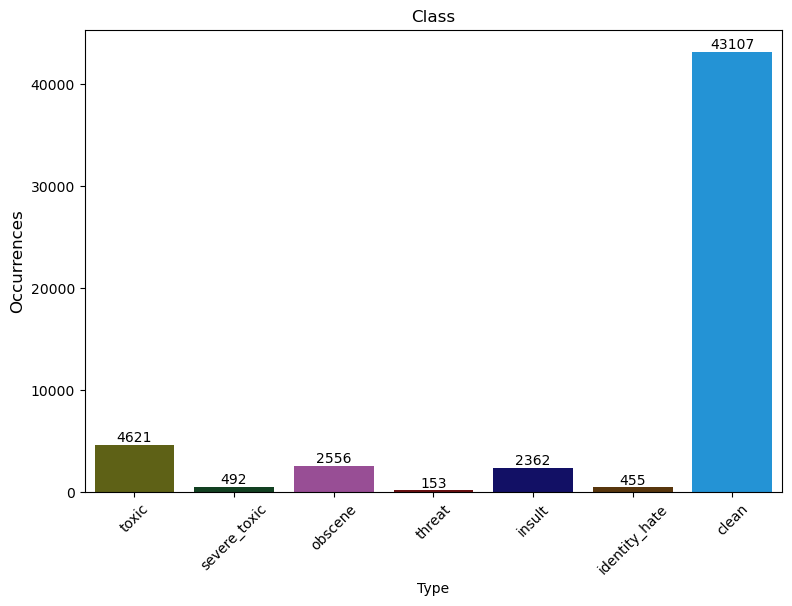

In [10]:

colors_list = ["brownish green", "pine green", "ugly purple",
               "blood", "deep blue", "brown", "azure"]

palette = sns.xkcd_palette(colors_list)

x = train_y_df.iloc[:, 0:].sum()

plt.figure(figsize=(9, 6))
ax = sns.barplot(x=x.index, y=x.values, palette=palette)
plt.title("Class")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Type')
plt.xticks(rotation=45)
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 10, label,
            ha='center', va='bottom')

plt.show()


In [11]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
remove_n = lambda x: re.sub("\n", " ", x)
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)
train_X = train_X.map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)
val_X = val_X.map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)
test_X = test_X.map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)



In [12]:
print(val_X)

13234        ifd  image matt chats to jinty   jpg listed...
63172     x     n    x      n        this formula does n...
137429    please stop  if you continue to vandalize page...
21595         i want to be a fuck you    that s a song  ...
45599        i know we aren t supposed to use straw poll...
                                ...                        
36986     rfc   hi  i m informing editors who have recen...
123799       likewise a belated   thank you   for the ad...
95823     milton cooper was a criminal   why you defendi...
36602     no clarity in varna status there is no informa...
154815    jensen   is particularly notable article becau...
Name: comment_text, Length: 16000, dtype: object


In [13]:
max_words = 48000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_X)

In [14]:
train_sequences = []
for seq in tokenizer.texts_to_sequences_generator(train_X):
    train_sequences.append(seq)

val_sequences = []
for seq in tokenizer.texts_to_sequences_generator(val_X):
    val_sequences.append(seq)


test_sequences = []

for seq in tokenizer.texts_to_sequences_generator(test_X):
    test_sequences.append(seq)
    
def find_max_list(list):
    list_len = [len(i) for i in list]
    return (max(list_len))

max_length = max(find_max_list(train_sequences),find_max_list(val_sequences), find_max_list(test_sequences))

train_padded_X = pad_sequences(train_sequences, maxlen=int(max_length/2))
val_padded_X = pad_sequences(val_sequences, maxlen=int(max_length/2))
test_padded_X = pad_sequences(test_sequences, maxlen=int(max_length/2))

print(val_sequences[0])


[13832, 123, 3501, 24929, 2, 30918, 445, 409, 12, 113, 30, 123, 27, 379, 484, 9, 6, 722, 27, 2106, 123, 3501, 24929, 2, 30918, 445, 44, 57, 409, 36, 29, 352, 5, 379, 12, 113, 48, 150, 43, 2, 66, 77, 13, 8, 6, 86, 19, 2, 640, 12, 1, 353, 4, 1, 123, 2, 146, 111, 562, 23, 6, 18, 510, 11, 10, 14, 90, 148, 130, 6, 39, 39]


### LTSM

In [15]:
inp = Input(shape=(int(max_length/2), ))
x = Embedding(max_words, 128)(inp)
x = LSTM(64, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.5)(x)

x = Dense(6, activation='sigmoid')(x)
model = Model(inputs=inp, outputs=x)

#print(model.summary())
model_2=Model(inputs=inp, outputs=x)
model_2.compile('adam', 'binary_crossentropy', metrics=['accuracy'])


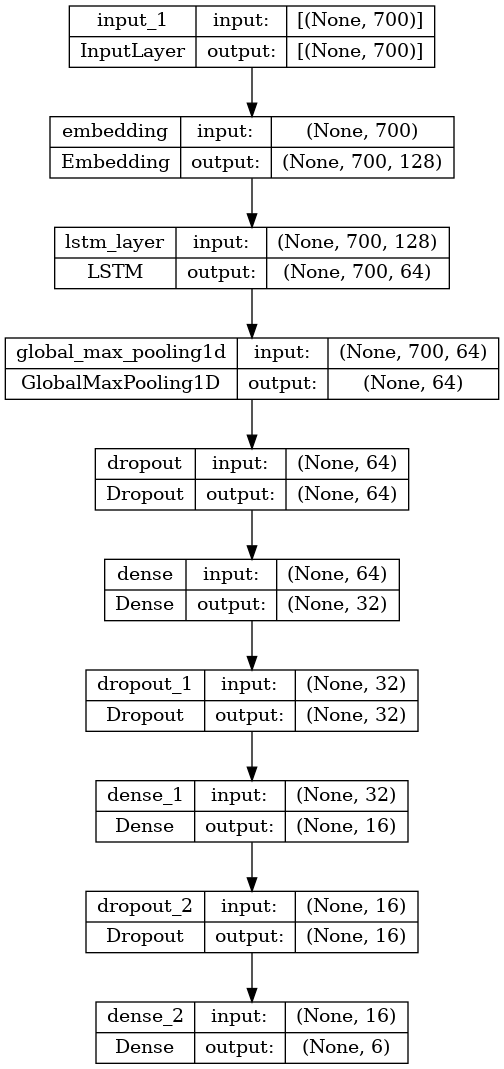

In [16]:
plot_model(model, show_shapes=True)

In [17]:
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_padded_X, train_Y,
          batch_size= 128,
          epochs=5,
          validation_data= [val_padded_X, val_Y])

Epoch 1/5
375/375 [==============================] - 86s 219ms/step - loss: 0.2501 - accuracy: 0.2879 - val_loss: 0.0754 - val_accuracy: 0.9933
Epoch 2/5
375/375 [==============================] - 62s 166ms/step - loss: 0.0798 - accuracy: 0.7389 - val_loss: 0.0610 - val_accuracy: 0.9933
Epoch 3/5
375/375 [==============================] - 48s 127ms/step - loss: 0.0622 - accuracy: 0.8925 - val_loss: 0.0603 - val_accuracy: 0.9933
Epoch 4/5
375/375 [==============================] - 44s 117ms/step - loss: 0.0535 - accuracy: 0.9464 - val_loss: 0.0607 - val_accuracy: 0.9933
Epoch 5/5
375/375 [==============================] - 36s 96ms/step - loss: 0.0480 - accuracy: 0.9689 - val_loss: 0.0679 - val_accuracy: 0.9933


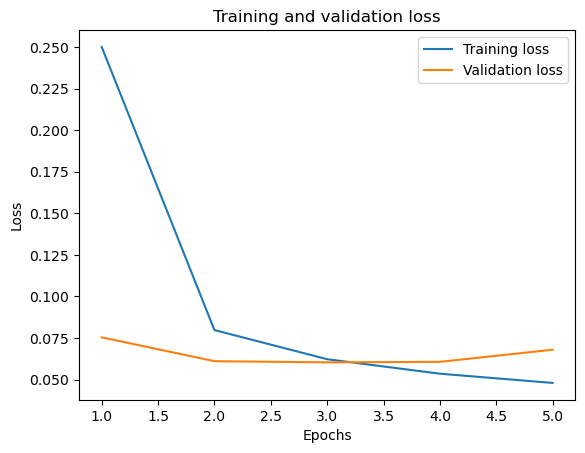

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

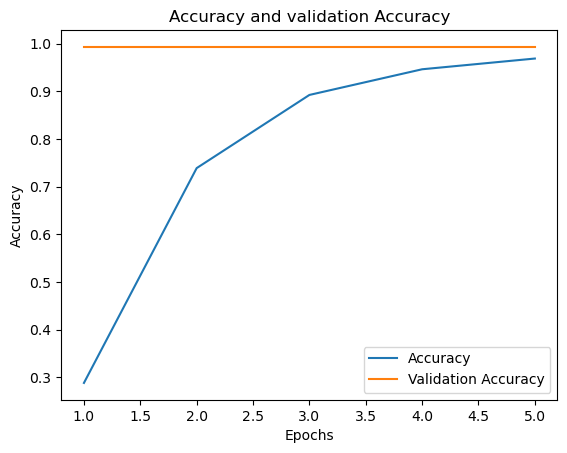

In [19]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Accuracy')
plt.plot(epochs, val_loss, label='Validation Accuracy')
plt.title('Accuracy and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

In [20]:
pred=model.predict(test_padded_X)
pred_2 = model.predict(train_padded_X)

# Convert predictions to one\s and zeros


1500/1500 [==============================] - 30s 20ms/step


In [21]:
pred_binary = np.where(pred > 0.5, 1, 0)
pred_2_binary = np.where(pred_2 > 0.5, 1, 0)

In [22]:
from sklearn.metrics import f1_score, confusion_matrix

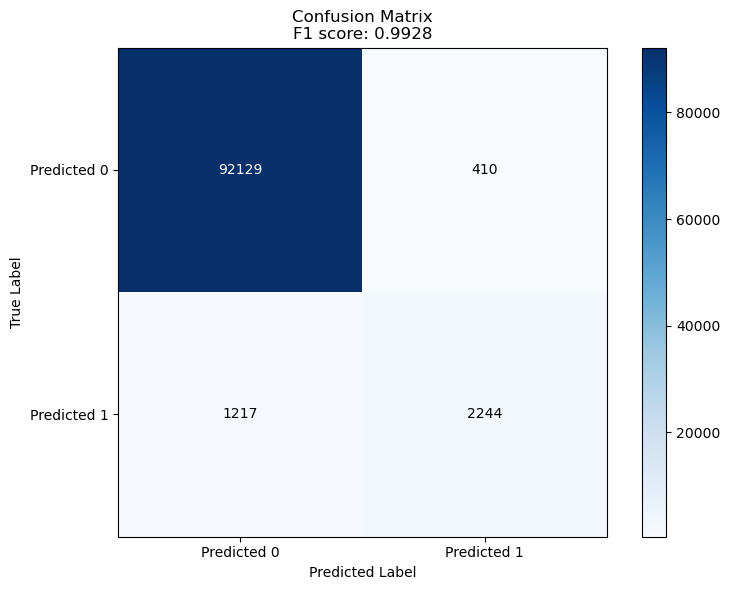

In [23]:
test_Y_single = np.argmax(test_Y, axis=1)
pred_single = np.argmax(pred_binary, axis=1)

#f1_score = f1_score(test_Y_single, pred_single, average='weighted')
f1_1 = f1_score(test_Y_single, pred_single, average='weighted')
# Get the number of classes
num_classes = len(list_classes)

# Calculate the confusion matrix
cm = np.zeros((2, 2))
for i in range(num_classes):
    true_positives = np.sum(np.logical_and(test_Y[:, i] == 1, pred_binary[:, i] == 1))
    false_positives = np.sum(np.logical_and(test_Y[:, i] == 0, pred_binary[:, i] == 1))
    true_negatives = np.sum(np.logical_and(test_Y[:, i] == 0, pred_binary[:, i] == 0))
    false_negatives = np.sum(np.logical_and(test_Y[:, i] == 1, pred_binary[:, i] == 0))

    cm[0, 0] += true_negatives
    cm[0, 1] += false_positives
    cm[1, 0] += false_negatives
    cm[1, 1] += true_positives

# Set the tick labels and locations
tick_labels = ['Predicted 0', 'Predicted 1']
tick_locations = np.arange(len(tick_labels))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=tick_locations, yticks=tick_locations,
       xticklabels=tick_labels, yticklabels=tick_labels,
       ylabel='True Label',
       xlabel='Predicted Label',
       title=f'Confusion Matrix\nF1 score: {f1_1:.4f}')

# Loop over data dimensions and create text annotations with appropriate color
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'  # Adjust text color based on cell value
        ax.text(j, i, format(int(cm[i, j]), 'd'), ha="center", va="center", color=text_color)

plt.tight_layout()
plt.show()

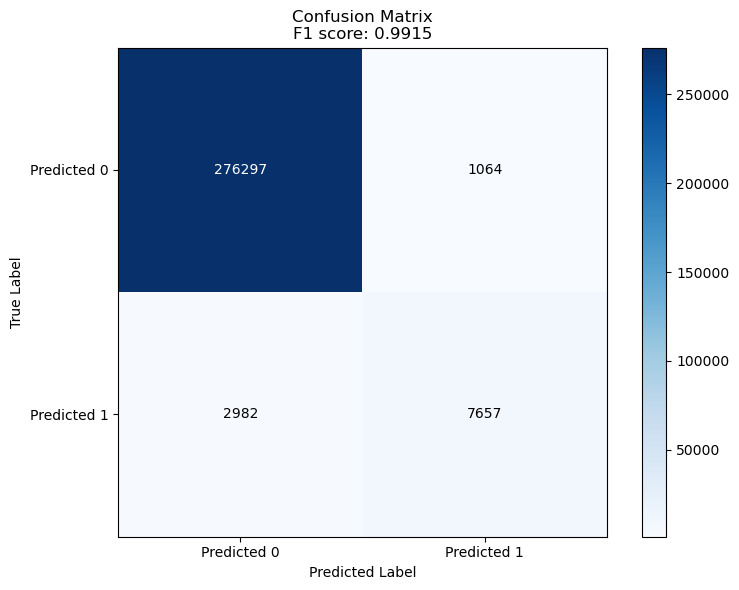

In [24]:
from sklearn.metrics import f1_score, confusion_matrix

train_Y_single = np.argmax(train_Y, axis=1)
pred2_single = np.argmax(pred_2_binary, axis=1)
cm = np.zeros((2, 2))
for i in range(num_classes):
    true_positives = np.sum(np.logical_and(train_Y[:, i] == 1, pred_2_binary[:, i] == 1))
    false_positives = np.sum(np.logical_and(train_Y[:, i] == 0, pred_2_binary[:, i] == 1))
    true_negatives = np.sum(np.logical_and(train_Y[:, i] == 0, pred_2_binary[:, i] == 0))
    false_negatives = np.sum(np.logical_and(train_Y[:, i] == 1, pred_2_binary[:, i] == 0))

    cm[0, 0] += true_negatives
    cm[0, 1] += false_positives
    cm[1, 0] += false_negatives
    cm[1, 1] += true_positives

# Set the tick labels and locations
tick_labels = ['Predicted 0', 'Predicted 1']
tick_locations = np.arange(len(tick_labels))

# Calculate the F1 score
f1_2 = f1_score(train_Y_single, pred2_single, average='weighted')

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=tick_locations, yticks=tick_locations,
       xticklabels=tick_labels, yticklabels=tick_labels,
       ylabel='True Label',
       xlabel='Predicted Label',
       title=f'Confusion Matrix\nF1 score: {f1_2:.4f}')

# Loop over data dimensions and create text annotations with appropriate color
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'  # Adjust text color based on cell value
        ax.text(j, i, format(int(cm[i, j]), 'd'), ha="center", va="center", color=text_color)

plt.tight_layout()
plt.show()

### GRU

In [25]:
from tensorflow.keras.layers import GRU, Dense, Dropout, Input, Embedding, GlobalMaxPool1D
from tensorflow.keras.models import Model

inp = Input(shape=(int(max_length/2), ))
x = Embedding(max_words, 128)(inp)
x = GRU(64, return_sequences=True, name='gru_layer')(x)  # Replace LSTM with GRU
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(6, activation='sigmoid')(x)

model = Model(inputs=inp, outputs=x)

print(model.summary())
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 700)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 700, 128)          6144000   
                                                                 
 gru_layer (GRU)             (None, 700, 64)           37248     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                           

In [26]:
history = model.fit(train_padded_X, train_Y,
          batch_size= 128,
          epochs=5,
          validation_data= [val_padded_X, val_Y])

Epoch 1/5
375/375 [==============================] - 61s 157ms/step - loss: 0.2298 - accuracy: 0.4991 - val_loss: 0.0760 - val_accuracy: 0.9644
Epoch 2/5
375/375 [==============================] - 45s 119ms/step - loss: 0.0798 - accuracy: 0.8678 - val_loss: 0.0648 - val_accuracy: 0.9933
Epoch 3/5
375/375 [==============================] - 39s 104ms/step - loss: 0.0629 - accuracy: 0.9668 - val_loss: 0.0594 - val_accuracy: 0.9933
Epoch 4/5
375/375 [==============================] - 37s 98ms/step - loss: 0.0545 - accuracy: 0.9869 - val_loss: 0.0645 - val_accuracy: 0.9933
Epoch 5/5
375/375 [==============================] - 34s 90ms/step - loss: 0.0491 - accuracy: 0.9882 - val_loss: 0.0679 - val_accuracy: 0.9933


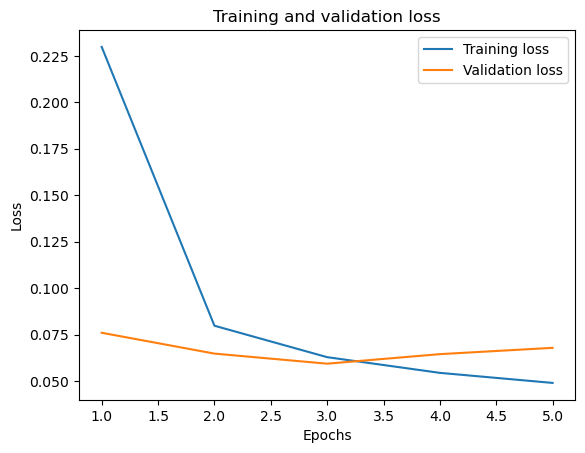

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

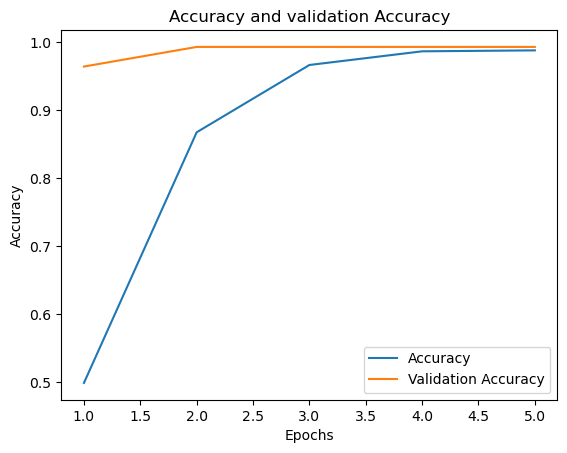

In [28]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Accuracy')
plt.plot(epochs, val_loss, label='Validation Accuracy')
plt.title('Accuracy and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

In [ ]:
pred=model.predict(test_padded_X)
pred_2 = model.predict(train_padded_X)
pred_binary = np.where(pred > 0.5, 1, 0)
pred_2_binary = np.where(pred_2 > 0.5, 1, 0)

1459/1500 [============================>.] - ETA: 0s

In [ ]:
test_Y_single = np.argmax(test_Y, axis=1)
pred_single = np.argmax(pred_binary, axis=1)

#f1_score = f1_score(test_Y_single, pred_single, average='weighted')
f1_1 = f1_score(test_Y_single, pred_single, average='weighted')
# Get the number of classes
num_classes = len(list_classes)

# Calculate the confusion matrix
cm = np.zeros((2, 2))
for i in range(num_classes):
    true_positives = np.sum(np.logical_and(test_Y[:, i] == 1, pred_binary[:, i] == 1))
    false_positives = np.sum(np.logical_and(test_Y[:, i] == 0, pred_binary[:, i] == 1))
    true_negatives = np.sum(np.logical_and(test_Y[:, i] == 0, pred_binary[:, i] == 0))
    false_negatives = np.sum(np.logical_and(test_Y[:, i] == 1, pred_binary[:, i] == 0))

    cm[0, 0] += true_negatives
    cm[0, 1] += false_positives
    cm[1, 0] += false_negatives
    cm[1, 1] += true_positives

# Set the tick labels and locations
tick_labels = ['Predicted 0', 'Predicted 1']
tick_locations = np.arange(len(tick_labels))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=tick_locations, yticks=tick_locations,
       xticklabels=tick_labels, yticklabels=tick_labels,
       ylabel='True Label',
       xlabel='Predicted Label',
       title=f'Confusion Matrix\nF1 score: {f1_1:.4f}')

# Loop over data dimensions and create text annotations with appropriate color
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'  # Adjust text color based on cell value
        ax.text(j, i, format(int(cm[i, j]), 'd'), ha="center", va="center", color=text_color)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix

train_Y_single = np.argmax(train_Y, axis=1)
pred2_single = np.argmax(pred_2_binary, axis=1)
cm = np.zeros((2, 2))
for i in range(num_classes):
    true_positives = np.sum(np.logical_and(train_Y[:, i] == 1, pred_2_binary[:, i] == 1))
    false_positives = np.sum(np.logical_and(train_Y[:, i] == 0, pred_2_binary[:, i] == 1))
    true_negatives = np.sum(np.logical_and(train_Y[:, i] == 0, pred_2_binary[:, i] == 0))
    false_negatives = np.sum(np.logical_and(train_Y[:, i] == 1, pred_2_binary[:, i] == 0))

    cm[0, 0] += true_negatives
    cm[0, 1] += false_positives
    cm[1, 0] += false_negatives
    cm[1, 1] += true_positives

# Set the tick labels and locations
tick_labels = ['Predicted 0', 'Predicted 1']
tick_locations = np.arange(len(tick_labels))

# Calculate the F1 score
f1_2 = f1_score(train_Y_single, pred2_single, average='weighted')

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=tick_locations, yticks=tick_locations,
       xticklabels=tick_labels, yticklabels=tick_labels,
       ylabel='True Label',
       xlabel='Predicted Label',
       title=f'Confusion Matrix\nF1 score: {f1_2:.4f}')

# Loop over data dimensions and create text annotations with appropriate color
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'  # Adjust text color based on cell value
        ax.text(j, i, format(int(cm[i, j]), 'd'), ha="center", va="center", color=text_color)

plt.tight_layout()
plt.show()